In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols, adfuller
from statsmodels.tsa.filters.hp_filter import hpfilter
import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AR,ARResults
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse,rmse




%matplotlib inline

In [2]:
df = pd.read_csv('arima_eda.csv')

In [ ]:
df.set_index('Date1', inplace=True) 
df.index=pd.to_datetime(df.index)

In [3]:
df.head()

,Date1,PowerA,PowerB,AirFlow_Zone4,dissolved02_All,dissolved02,Hour,Day
0,2019-08-13 16:00:00,1.034467e+06,483884.59070,3512.446118,1.663969,1.479520,16,Tue
1,2019-08-13 20:00:00,1.232730e+06,489331.77670,3528.054032,1.546575,1.511921,20,Tue
2,2019-08-14 00:00:00,1.020047e+06,378832.87310,3862.125437,1.958906,1.850203,0,Wed
3,2019-08-14 04:00:00,9.212818e+05,31880.01050,3915.824151,2.249302,2.286969,4,Wed
4,2019-08-14 08:00:00,1.214494e+06,66504.77959,3633.866031,1.902027,1.926427,8,Wed


In [4]:
temp = pd.read_excel('wbp_weather.xlsx')
temp_avg = pd.DataFrame()
temp_avg['avg'] = temp.avg.repeat(6)

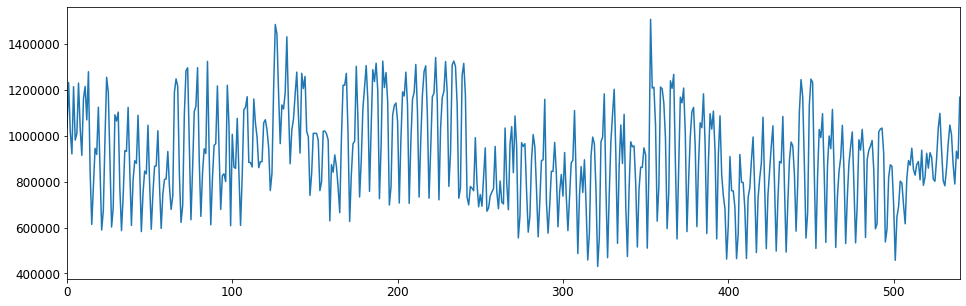

In [5]:
#Visual of power source A power usage 
df['PowerA'].plot(figsize=(16,5), fontsize=12);

In [6]:
# Creating a new DF for Power A for some additional Analysis 
df_a = pd.DataFrame(index=df.index, columns= ('PowerA', 'Hour'))
df_a['PowerA'] = df['PowerA']
df_a['Hour'] = df['Hour']
df_a.index.freq = '4H'

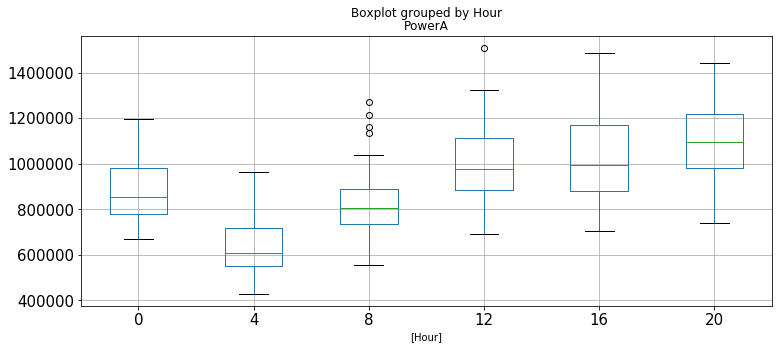

In [7]:
# Hourly Power Consumption grouped by hour 
# Can see a clear trend 4 A.M. lowest usage and 8 P.M. Highest usage 
df_a.boxplot(by='Hour',figsize=(12,5), fontsize=15);

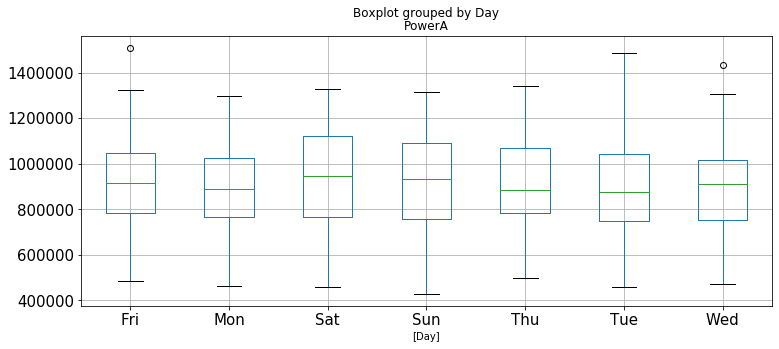

In [8]:
#No real clear trend.  Would probably need more data to determine if there is a difference 
df_a_day = pd.DataFrame(index=df.index)
df_a_day['PowerA'] = df['PowerA']
df_a_day['Day'] = df['Day']
df_a_day.boxplot(by='Day',figsize=(12,5), fontsize=15);

## ETS Decomposition 

In [14]:
df.head()

,Date1,PowerA,PowerB,AirFlow_Zone4,dissolved02_All,dissolved02,Hour,Day
0,2019-08-13 16:00:00,1.034467e+06,483884.59070,3512.446118,1.663969,1.479520,16,Tue
1,2019-08-13 20:00:00,1.232730e+06,489331.77670,3528.054032,1.546575,1.511921,20,Tue
2,2019-08-14 00:00:00,1.020047e+06,378832.87310,3862.125437,1.958906,1.850203,0,Wed
3,2019-08-14 04:00:00,9.212818e+05,31880.01050,3915.824151,2.249302,2.286969,4,Wed
4,2019-08-14 08:00:00,1.214494e+06,66504.77959,3633.866031,1.902027,1.926427,8,Wed


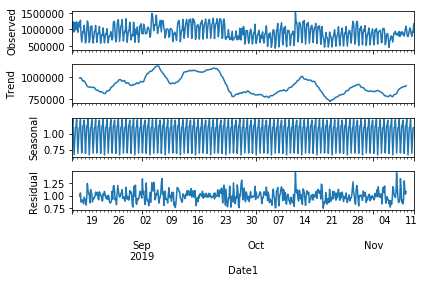

In [21]:
power_a_result = seasonal_decompose(df['PowerA'], model='multiplicative') 
power_a_result.plot();
#Trend - Genearl Pattern Overtime.  September highest Usage 
#Seasonal - Daily Cycles
# Residual - Any data not explained by the Trend or Seasonality

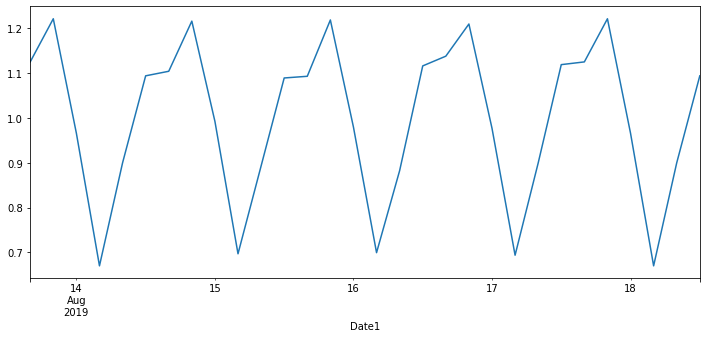

In [30]:
# Zoomed in  on the seasonal portion and can clearly see that there is daily seasonality.  
ax, fig = ig, ax = plt.subplots(figsize=(12,5))
power_a_result.seasonal[:30].plot()

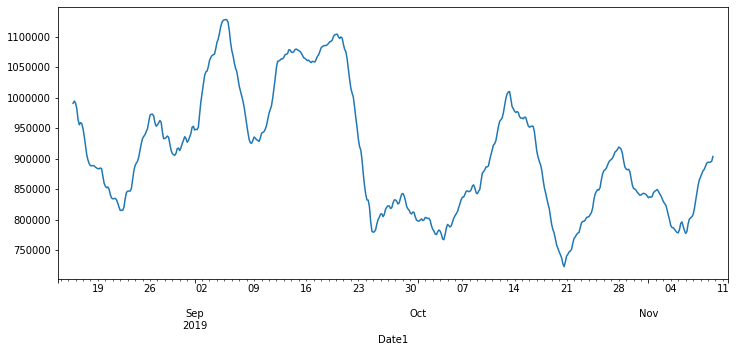

In [29]:
power_a_result.trend.plot(figsize=(12,5))

## Forecast Modeling - Exponential Smoothing 
### Holt-Winters

In [32]:
train_data = df_a.iloc[:529]
test_data = df_a.iloc[529:]
train_data = train_data.astype('double')

# Fits the Train Data to the Exponential Smoothing Model
fitted_model = ExponentialSmoothing(train_data['PowerA'],trend='mul',seasonal='mul',seasonal_periods=6).fit()

# Fits the Test Predictions
test_predictions = fitted_model.forecast(12).rename('Holt-Winters Forecast')

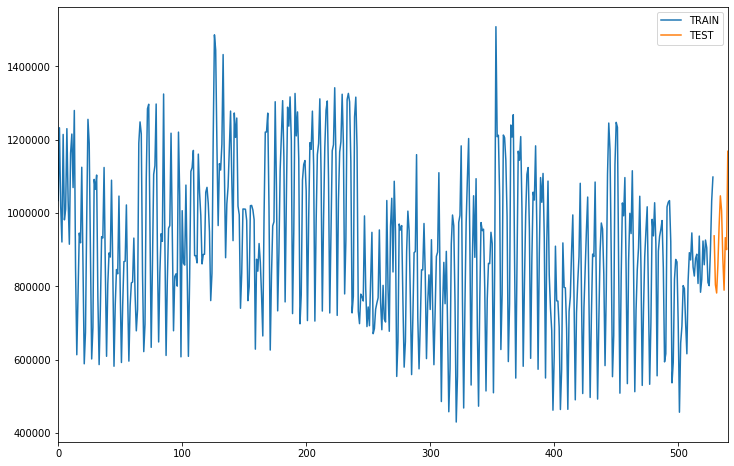

In [33]:
# Forecasts two days into the future using exponential smoothing 
train_data['PowerA'].plot(legend=True,label='TRAIN')
test_data['PowerA'].plot(legend=True,label='TEST',figsize=(12,8));

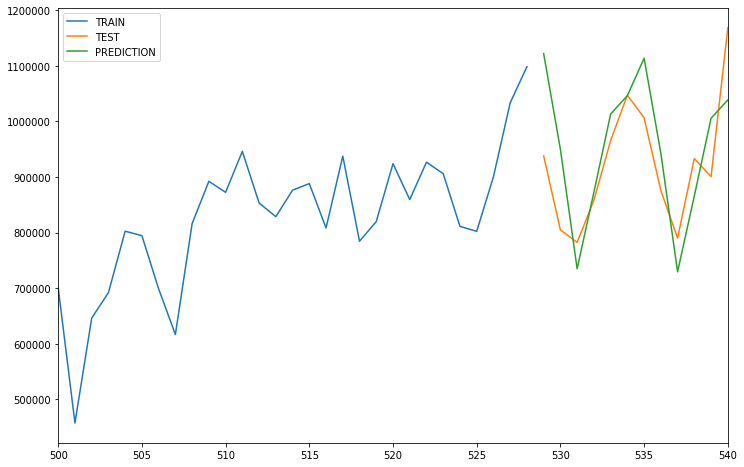

In [36]:
# Prediction 
train_data['PowerA'][500:].plot(legend=True,label='TRAIN')
test_data['PowerA'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

#### Evaluating Results:
Not the Best Model. Predicting Two days into the future will give a general idea of the trend, but there is still a wide margin of error.

## Autocorrelation / Partial Autocorrelation Functions

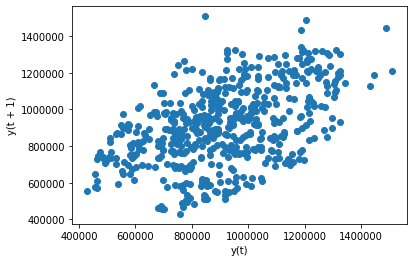

In [38]:
# Slight Positive Correlation
lag_plot(df_a['PowerA']);

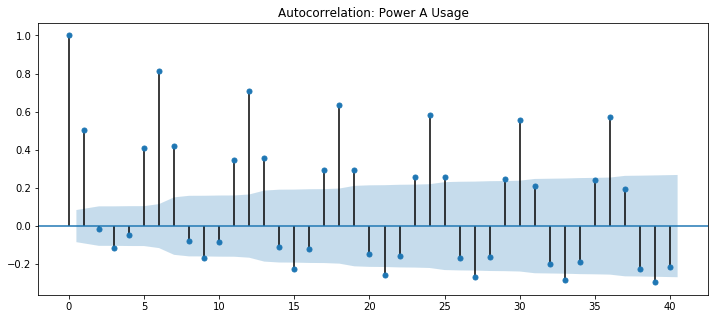

In [39]:
# Can see that every 6th lag has a high correlation.  This makes sense since the daily cycles repeat every 6 
# Data points 
title = 'Autocorrelation: Power A Usage'
lags = 40
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(df_a['PowerA'],title=title,lags=lags, ax=ax);

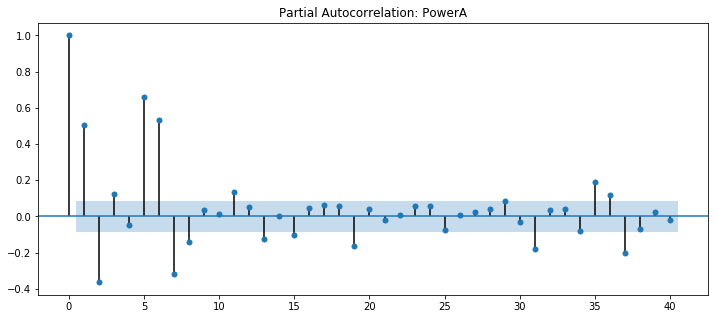

In [40]:
# Drops off a lot faster which is expected 
title='Partial Autocorrelation: PowerA'
lags=40
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(df_a['PowerA'],title=title,lags=lags, ax=ax);

## Auto Regression
Below Code is using a AR lag of 1.  This portion of purely an exploritory step inorder to find the best AR Lag for this data.   

In [41]:
train_data = df_a.iloc[:529]
test_data = df_a.iloc[529:]

model = AR(train_data['PowerA'])
AR1fit = model.fit(maxlag=1,method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')



Lag: 1
Coefficients:
const        448650.355324
L1.PowerA         0.507434
dtype: float64


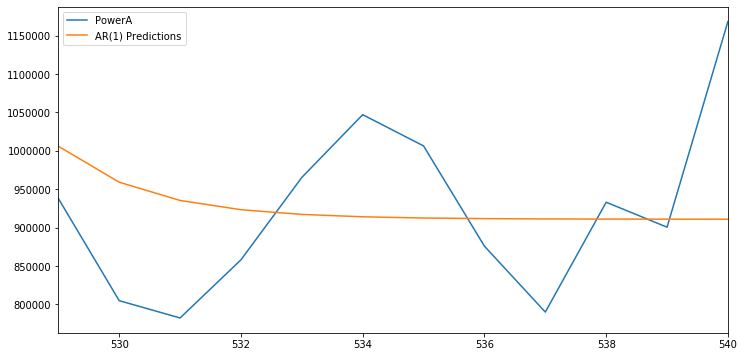

In [44]:
# Not a very good prediction.  Way to smooth for the model 
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6));

### AR maxlag order of 2

Lag: 2
Coefficients:
const        613042.013524
L1.PowerA         0.691050
L2.PowerA        -0.364610
dtype: float64


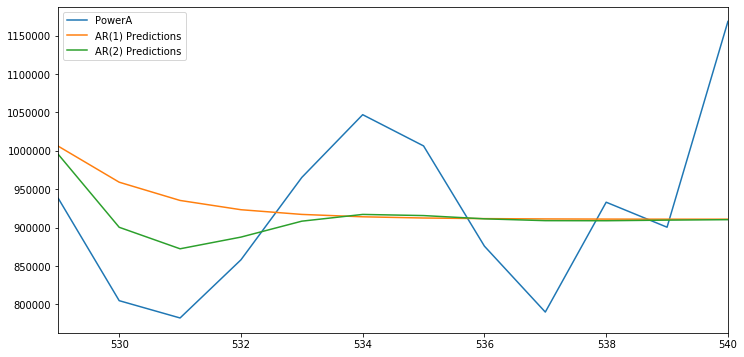

In [75]:
# Autoregression lag of 2 fits the model a little better, but still to smooth overall 
AR2fit = model.fit(maxlag=2,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

### Graphing out Auto Regression Lags 3 - 10 to see how the predictions improve 

Lag: 3
Coefficients:
const        532701.237001
L1.PowerA         0.738950
L2.PowerA        -0.454618
L3.PowerA         0.130463
dtype: float64


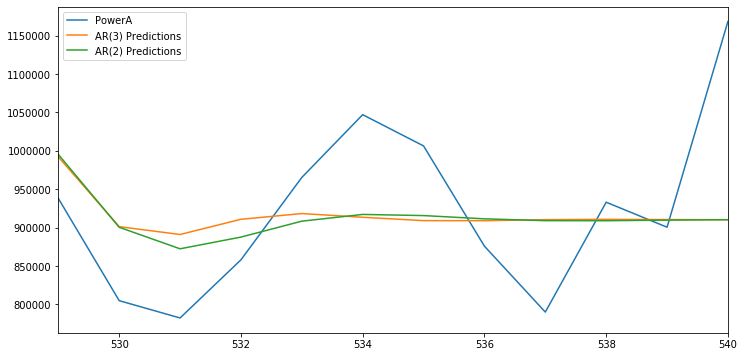

In [76]:
AR2fit = model.fit(maxlag=3,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions3 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(3) Predictions')
test_data['PowerA'].plot(legend=True)
predictions2.plot(legend=True)
predictions3.plot(legend=True,figsize=(12,6));

Lag: 4
Coefficients:
const        562007.811867
L1.PowerA         0.745675
L2.PowerA        -0.479188
L3.PowerA         0.169964
L4.PowerA        -0.053879
dtype: float64


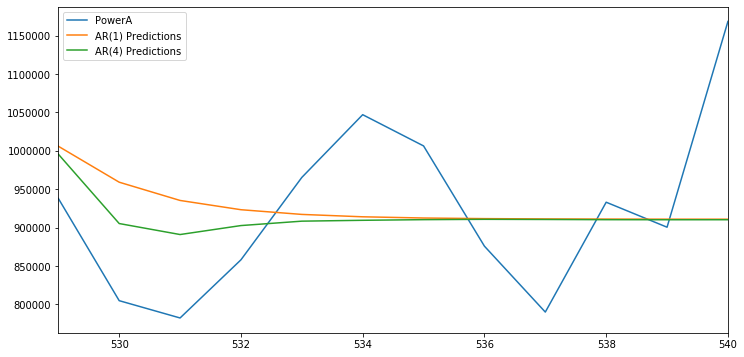

In [64]:
AR2fit = model.fit(maxlag=4,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(4) Predictions')
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

Lag: 5
Coefficients:
const        193260.901240
L1.PowerA         0.779205
L2.PowerA        -0.589272
L3.PowerA         0.485780
L4.PowerA        -0.547803
L5.PowerA         0.660737
dtype: float64


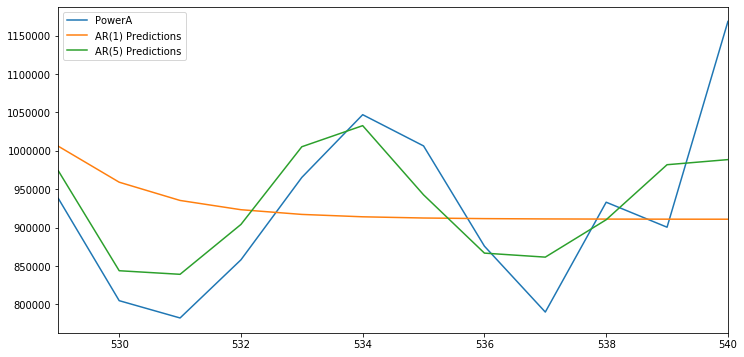

In [65]:
AR2fit = model.fit(maxlag=5,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(5) Predictions')
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

Lag: 6
Coefficients:
const        96124.660628
L1.PowerA        0.438619
L2.PowerA       -0.308799
L3.PowerA        0.237591
L4.PowerA       -0.243837
L5.PowerA        0.259952
L6.PowerA        0.512203
dtype: float64


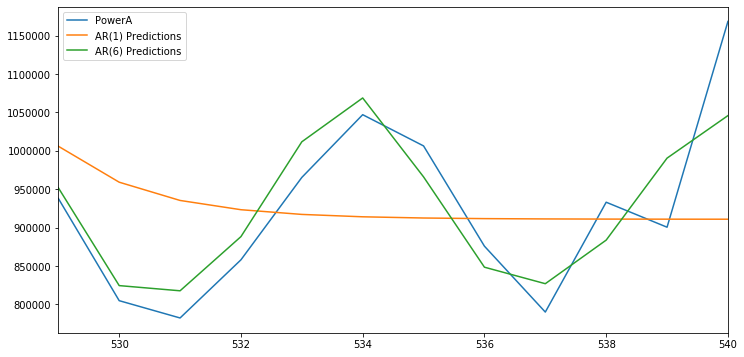

In [66]:
AR2fit = model.fit(maxlag=6,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(6) Predictions')
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

Lag: 7
Coefficients:
const        124619.763009
L1.PowerA         0.605664
L2.PowerA        -0.224233
L3.PowerA         0.159252
L4.PowerA        -0.168373
L5.PowerA         0.159641
L6.PowerA         0.654617
L7.PowerA        -0.322474
dtype: float64


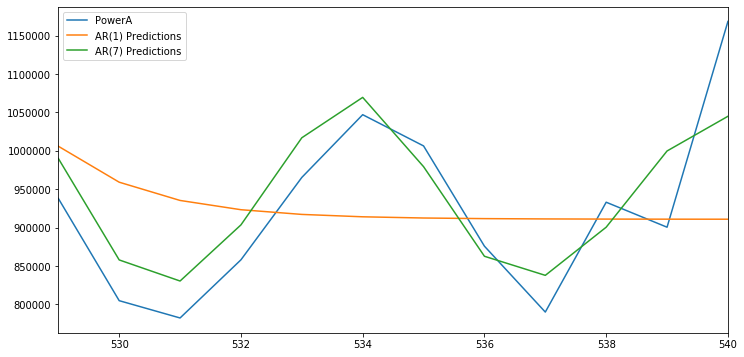

In [67]:
AR2fit = model.fit(maxlag=7,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(7) Predictions')
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

Lag: 8
Coefficients:
const        139559.913299
L1.PowerA         0.566605
L2.PowerA        -0.144611
L3.PowerA         0.178612
L4.PowerA        -0.188354
L5.PowerA         0.178082
L6.PowerA         0.627355
L7.PowerA        -0.249372
L8.PowerA        -0.120707
dtype: float64


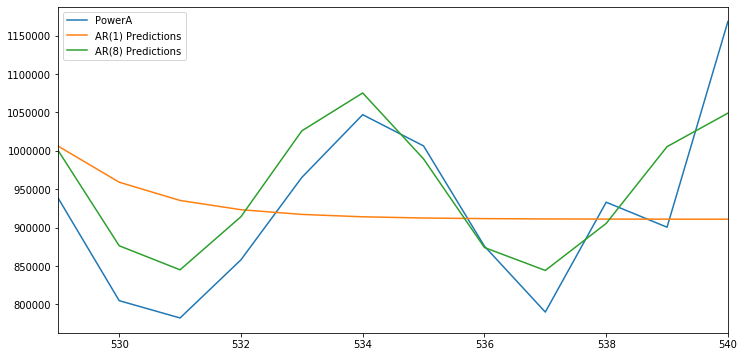

In [68]:
AR2fit = model.fit(maxlag=8,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(8) Predictions')
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

Lag: 9
Coefficients:
const        134646.173073
L1.PowerA         0.571425
L2.PowerA        -0.134589
L3.PowerA         0.153301
L4.PowerA        -0.195677
L5.PowerA         0.185406
L6.PowerA         0.620367
L7.PowerA        -0.243592
L8.PowerA        -0.143460
L9.PowerA         0.039866
dtype: float64


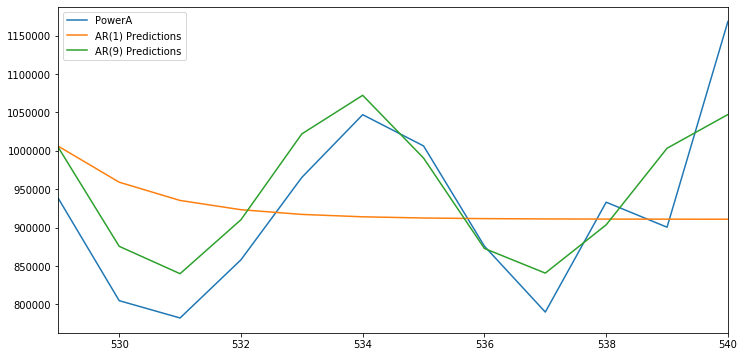

In [69]:
AR2fit = model.fit(maxlag=9,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(9) Predictions')
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

Lag: 10
Coefficients:
const         133672.663487
L1.PowerA          0.571340
L2.PowerA         -0.133957
L3.PowerA          0.154337
L4.PowerA         -0.198219
L5.PowerA          0.184709
L6.PowerA          0.621231
L7.PowerA         -0.244185
L8.PowerA         -0.142871
L9.PowerA          0.037574
L10.PowerA         0.004155
dtype: float64


/Users/eric/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


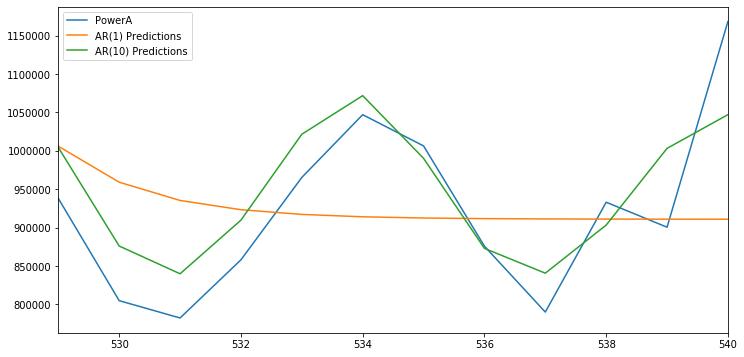

In [70]:
AR2fit = model.fit(maxlag=10,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(10) Predictions')
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

#### As expected in this portion a lag of around 6 is where the prediction using AR starts to really become significant.  This makes sense because a cycle is every 6 data points or 24 hours. 